## What to expect as an Airbnb Host in Berlin

Airbnb has successfully disrupted the traditional hospitality industry as more and more travellers decide to use Airbnb as their premier accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth with the number of rentals listed on its website growing exponentially each year.

In Germany, no city is more popular than Berlin, the capital at the river Spree. That implies, Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018. With a size of 891 km², this means there are roughly 25 homes being rented out per km² in Berlin on Airbnb!

Considerung the possibility I would have to relocate for a new data science job but want to keep my current flat in Berlin (which is quite cheap!) , I would wonder if it is worth to offer my jewel on Airbnb. Could this perhaps be a profitable option? However, for potential hosts it is difficult to know what the true value of their home is and how much their home might be damanded. And is there anything else a host can influence other than location and furniture, which are obviously often fixed - such as description, communication patterns, services to boost their earnings?

The following three questions will drive this project:

> **1. Can we recommend a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Berlin?** <br>
> **2. How big is the demand likely to be? What can a host expect with respect to occupancy and earnings here in Berlin? And what does the demand depend on?** <br>
> **3. And lastly: What do visitors like and dislike?**

The **first question** focuses on the accommodation features and initial presentation decisions a new host can make: i.e. whether to picture herself/himself at the website, how many minimum nights, whether to offer instant bookings etc. A machine learning algorithm will be applied to try to get an answer. **The second question** is similar and even stronger focuses on geography to explain the demand, but will use mainly visualizations to narrow down the search for answers. However, the **last question** processes the reviews to find out what people prefer and reject. Natural Language Processing (NLP) and specifically Sentiment Analysis are what we make use of here.

To not prevent my notebook(s) from ever being read by their very length, I wrote one "paper", aka notebook, for each question. The first notebook can be found here (**Insert Link!!!!**) and the third one here (**Insert Link!!!!**).

### The datasets

In the second notebook, I will combine the summary listings and the detailed listings for Berlin sourced from the Inside Airbnb website. The goal is to visualize the rental landscape and try to understand the aspects driving the demand. Both datasets were scraped 07 Nov 2018.

## > No. 2 _ Explaining the Demand & Expected Earnings
<a id='Table of contents'></a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Trimming the Dataset'> 2.1. Trimming the Dataset </a>
* <a href='#2.2. Cleaning the Price Columns'> 2.2. Cleaning the Price Columns </a>
* <a href='#2.3. Types of Lodgings'> 2.3. Types of Lodgings </a>
* <a href='#2.4. Cleaning the *reviews_per_month* Column'> 2.4. Cleaning the *reviews_per_month* Column </a>
* <a href='#2.5. Calculating Occupancies'> 2.5. Calculating Occupancies </a>
* <a href='#2.6. Calculating Earnings'> 2.6. Calculating Earnings </a>

### <a href='#3. Visualizing the Data'> 3. Visualizing the Data </a>
* <a href='#3.1. Getting Started with a Heat Map'> 3.1. Getting Started with a Heat Map </a>
* <a href='#3.2. Demand by District'> 3.2. Demand by District </a>
* <a href='#3.3. Demand by Size'> 3.3. Demand by Size </a>
* <a href='#3.4. Demand by Price'> 3.4. Demand by Price </a>
* <a href='#3.5. Demand by Status "Super-Host"'> 3.5. Demand by Status "Super-Host" </a>

### <a href='#4. Interpreting the Data'> 4. Interpreting the Data </a>

### <a href='#5. Appendix'> 5. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import folium

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_1 = pd.read_csv('data/insideAirbnb/listings.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_1.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 22552 rows and 16 columns.
It contains 0 duplicates.


In [3]:
df_1.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0


In [4]:
df_1.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Trimming the Dataset
<a id='2.1. Trimming the Dataset'></a>

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'price', 'reviews_per_month', 'neighbourhood_group', 'latitude', 'longitude']

df_1 = df_1[columns_to_keep]
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_1.shape))

The dataset has 22552 rows and 6 columns - after dropping irrelevant columns.


In [6]:
df_2 = pd.read_csv('data/insideAirbnb/listings.csv.gz')

# merging my full df_1 + add only the cleaning fee in df_2
df = pd.merge(df_1, df_2[['cleaning_fee', 'property_type', 'accommodates',
                          'bathrooms', 'bedrooms', 'bed_type', 'host_is_superhost', 'id']], 
              on='id', how='left')

print("The dataset has {} rows and {} columns - after trimming it.".format(*df.shape))

The dataset has 22552 rows and 13 columns - after trimming it.


In [7]:
df.head(2)

,id,price,reviews_per_month,neighbourhood_group,latitude,longitude,cleaning_fee,property_type,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost
0,2015,60,3.76,Mitte,52.534537,13.402557,$30.00,Guesthouse,3,1.0,1.0,Real Bed,t
1,2695,17,1.42,Pankow,52.548513,13.404553,$0.00,Apartment,2,1.0,1.0,Real Bed,f


#### 2.2. Cleaning the Price Columns
<a id='2.2. Cleaning the Price Columns'></a>

In [8]:
# checking Nan's in "price" column
df.price.isna().sum()

0

In [9]:
df['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

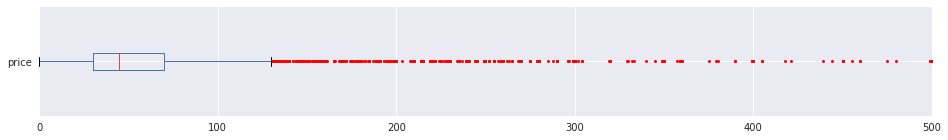

In [10]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 500), vert=False, flierprops=red_square, figsize=(16,2));

The description and boxplot above for price extremely skewed with a long tail of high-priced rentals, while 75% of all rentals cost 75 Euro  at the maximum. For this project,let's remove extremely high priced rentals above € 300/night to maintain comparability. (It is also unlikely that we have enough data to make tailored predictions for such bespoke listings.)

In [11]:
df.drop(df[df['price'] > 300].index, axis=0, inplace=True)

In [12]:
# checking Nan's in "cleaning_fee" column
df.cleaning_fee.isna().sum()

7069

There are plenty of Nan's. My serious guess is that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

In [13]:
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee.isna().sum()

0

In [14]:
# clean up cleaning_fee column (by method chaining)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float).astype(int)

# add price and cleaning_fee to total_price
df['total_price'] = df['price'] + df['cleaning_fee']

# reorder the columns to be more user friendly
df = df[['id', 'neighbourhood_group', 'reviews_per_month', 'price', 'cleaning_fee', 
         'total_price', 'accommodates', 'bathrooms', 'bedrooms', 'bed_type', 'property_type',
         'host_is_superhost', 'latitude', 'longitude']]

df.head(2)

,id,neighbourhood_group,reviews_per_month,price,cleaning_fee,total_price,accommodates,bathrooms,bedrooms,bed_type,property_type,host_is_superhost,latitude,longitude
0,2015,Mitte,3.76,60,30,90,3,1.0,1.0,Real Bed,Guesthouse,t,52.534537,13.402557
1,2695,Pankow,1.42,17,0,17,2,1.0,1.0,Real Bed,Apartment,f,52.548513,13.404553


#### 2.3. Types of Lodgings
<a id='2.3. Types of Lodgings'></a>

How many different property types are we up against?

In [15]:
df.property_type.value_counts(normalize=True)

Apartment                 0.899942
Condominium               0.027159
Loft                      0.019744
House                     0.017421
Serviced apartment        0.006924
Hostel                    0.005494
Townhouse                 0.004378
Guest suite               0.003305
Bed and breakfast         0.002859
Guesthouse                0.002546
Other                     0.002010
Boutique hotel            0.001742
Hotel                     0.001385
Bungalow                  0.000849
Boat                      0.000625
Tiny house                0.000536
Camper/RV                 0.000491
Houseboat                 0.000447
Villa                     0.000447
Pension (South Korea)     0.000313
Aparthotel                0.000268
Cabin                     0.000268
Cottage                   0.000179
Resort                    0.000134
Castle                    0.000089
Train                     0.000089
Casa particular (Cuba)    0.000089
Cave                      0.000045
Island              

Okay, an island, a train, even a villa are very rare and may also be extreme outliers with respect to the price. Let's focus on apartments only which make up the bulk of all listings:

In [16]:
df.drop(df[df.property_type != 'Apartment'].index, axis=0, inplace=True)

# if only apartments are left, we may drop column "property_type" as it offers no value any more
df.drop(['property_type'], axis=1, inplace=True)

print("The dataset has {} rows and {} columns - after removing all property types but apartments."
      .format(*df.shape))

The dataset has 20147 rows and 13 columns - after removing all property types but apartments.


#### 2.4. Cleaning the *reviews_per_month* Column
<a id='2.4. Cleaning the *reviews_per_month* Column'></a>

In [17]:
print('NaNs in reviews_per_month')
print('... in absolute number:', df.reviews_per_month.isna().sum())
print('... in percentage:     ', round(df.reviews_per_month.isna().sum()/len(df), 3), '%')

NaNs in reviews_per_month
... in absolute number: 3430
... in percentage:      0.17 %


It is evident to me that rentals without a value in the reviews_per_month column may only be listed recently or do not have enough reviews to calculate such a score. It may be painful, but necessary to drop these records instead of filling the values with a mean, median or by predicting them - this doesn't seem to be reasonable.

In [18]:
df.dropna(subset=['reviews_per_month'], inplace=True)

print("The dataset has {} rows and {} columns - after removing rows with missing values in reviews_per_month."
      .format(*df.shape))

The dataset has 16717 rows and 13 columns - after removing rows with missing values in reviews_per_month.


#### 2.5. Calculating Occupancies
<a id='2.5. Calculating Occupancies'></a>

One of the biggest issues with Airbnb is to get the occupancy rate for each host or for a market. Inside Airbnb, the website I sourced the data from, uses an occupancy model which they call the "San Francisco Model which uses a methodology as follows:

1. A **Review Rate** of 50% is used to convert reviews to estimated bookings. Other administrative authorities mentioned at Airbnb use a review rate of 72% (however this may be attributed to an unreliable source: Airbnb's CEO and co-founder Brian Chesky) - or one of 30.5% (based on comparing public data of reviews to the The New York Attorney General’s report on Airbnb released in October 2014.) Inside Airbnb chose 50% as it sits almost exactly between 72% and 30.5%. It basically means that only 50% of all visitors write a review, that implies that the number of reviews * the review rate gives an estimation of actual visitors.
2. An **average length of stay** is configured for each city, and this, multiplied by the estimated bookings for each listing over a period **gives the occupancy rate**.
3. The **earnings** can then be calculated by multiplying the occupancy rate with the price and the time period:

>**Monthly Occupancy Rate = Average Length of Stay (for Berlin) * (No of reviews per month / Review Rate)**<br>
*According to the latest update of Airbnb itself, guests who booked via Airbnb in Berlin in 2017, spent 4.2 nights 
on average here.*

>**Yearly Earnings = Monthly Occupancy Rate * Price * 12 months**

**Conservative Estimation**

With a very modest review rate of 0.5 we assume that only every second guest left a review. So let's calculate this conservative estimation of occupancy first:

In [19]:
avg_length_of_stay_berlin = 4.2
review_rate = 0.5

# calculate the occupancy and round the result
df['low_occupancy'] = round(avg_length_of_stay_berlin * (df['reviews_per_month'] / review_rate), 2)

# occupancy cannot be greater than 100% - do we have any outliers?
len(df[df['low_occupancy'] > 100])

6

In [20]:
# Yes, so let's drop them:
df.drop(df[df['low_occupancy'] > 100].index, axis=0, inplace=True)

# ... and check the distribution
#df['low_occupancy'].describe()

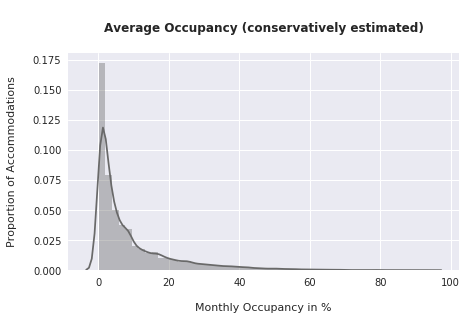

In [21]:
# plot
plt.figure(figsize=(7,4))
plt.title('\nAverage Occupancy (conservatively estimated)\n', fontweight='bold')
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')
sns.distplot(df['low_occupancy'], axlabel='', color='dimgrey');

**Progressive Estimation**

Now let's reach it for a more progressive estimation of occupancy using a review rate of 0.305 which assumes that 70% of all guest who were actually here left a review:

In [22]:
review_rate = 0.305

# calculate the occupancy and round the result
df['mid_occupancy'] = round(avg_length_of_stay_berlin * (df['reviews_per_month'] / review_rate), 2)

# Occupancy cannot be greater than 100% - do we have any outliers?
len(df[df['mid_occupancy'] > 100])

102

In [23]:
# Yes, so let's drop them:
df.drop(df[df['mid_occupancy'] > 100].index, axis=0, inplace=True)

# ... and check the distribution
#df['mid_occupancy'].describe()

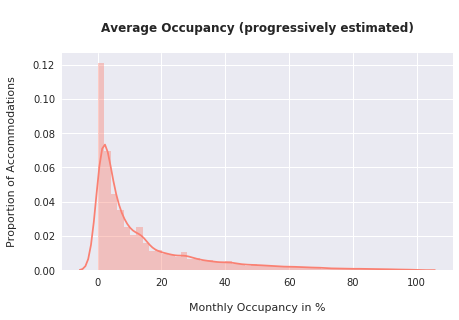

In [24]:
# plot
plt.figure(figsize=(7,4))
plt.title('\nAverage Occupancy (progressively estimated)\n', fontweight='bold')
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')
sns.distplot(df['mid_occupancy'], axlabel='', color='salmon');

**Comparing Occupancy Estimations**

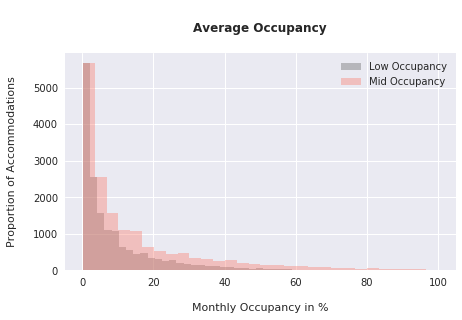

In [25]:
plt.figure(figsize=(7,4))
plt.title('\nAverage Occupancy\n', fontweight='bold')
plt.xlabel('\nMonthly Occupancy in %')
plt.ylabel('Proportion of Accommodations\n')
sns.distplot(df['low_occupancy'], color='dimgrey', axlabel='', label='Low Occupancy', bins=30, kde=False)
sns.distplot(df['mid_occupancy'], color='salmon',  axlabel='', label='Mid Occupancy', bins=30, kde=False)
plt.legend();

#### 2.6. Calculating Earnings
<a id='2.6. Calculating Earnings'></a>

**Conservative Estimation of Earnings**

In [26]:
# Yearly Earnings = Monthly Occupancy Rate * Price * 12 months
df['low_earnings'] = df['low_occupancy'] * df['price'] * 12
#df.low_earnings.describe()

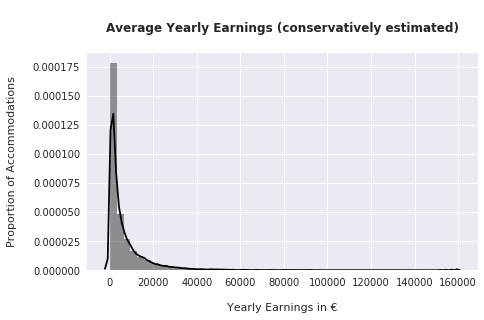

In [27]:
# plot
plt.figure(figsize=(7,4))
plt.title('\nAverage Yearly Earnings (conservatively estimated)\n', fontweight='bold')
plt.xlabel('\nYearly Earnings in €')
plt.ylabel('Proportion of Accommodations\n')
sns.distplot(df['low_earnings'], axlabel='', color='black');

**Progressive Estimation of Earnings**

In [28]:
# Yearly Earnings = Monthly Occupancy Rate * Price * 12 months
df['mid_earnings'] = df['mid_occupancy'] * df['price'] * 12
#df.mid_earnings.describe()

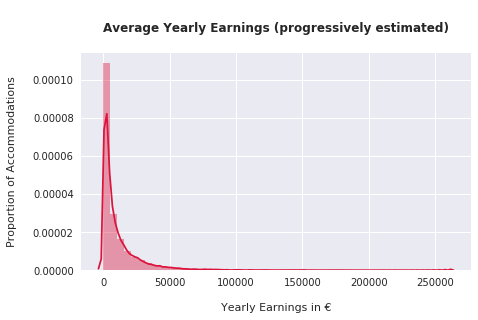

In [29]:
# plot
plt.figure(figsize=(7,4))
plt.title('\nAverage Yearly Earnings (progressively estimated)\n', fontweight='bold')
plt.xlabel('\nYearly Earnings in €')
plt.ylabel('Proportion of Accommodations\n')
sns.distplot(df['mid_earnings'], axlabel='', color='crimson');

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Visualizing the Data
<a id='3. Visualizing the Data'></a>

#### 3.1. Getting Started with a Heat Map
<a id='3.1. Getting Started with a Heat Map'></a>

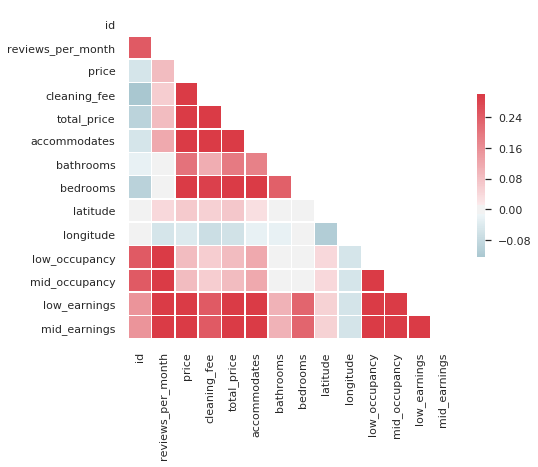

In [30]:
sns.set(style="white")
corr = df.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(8, 6))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5});

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.2. Demand by District
<a id='3.2. Demand by District'></a>

In [39]:
sns.set_style("dark")

def lollipop_highlight(dataframe, y_col, y_highlight, x_col):
    # prepare data
    df_plot = dataframe[[y_col, x_col]].groupby(y_col).apply(lambda x: x.mean())
    df_plot.sort_values(x_col, inplace=True)
    df_plot.reset_index(inplace=True)

    # highlight district specified as y_highlight
    my_color = np.where(df_plot[y_col] == y_highlight, 'crimson', 'skyblue')
    my_size  = np.where(df_plot[y_col] == y_highlight, 70, 30)

    # draw plot
    fig, ax = plt.subplots(figsize=(8,6))
    ax.hlines (y=df_plot.index, xmin=0, xmax=df_plot[x_col], color=my_color, alpha=0.5, linewidth=2)
    ax.scatter(y=df_plot.index, x=df_plot[x_col], s=my_size, color=my_color, alpha=1)

    # title, label, ticks and xlim
    ax.set_title('\nLollipop Chart No. 1: Average Occupancy by District\n', fontdict={'size':12, 'weight':'bold'})
    ax.set_xlabel('Occupancy in %')
    ax.set_yticks(df_plot.index)
    ax.set_yticklabels(df_plot[y_col], rotation=0, 
                       fontdict={'horizontalalignment': 'right', 'size':12})
    ax.set_xlim(0, 30)
    plt.show()

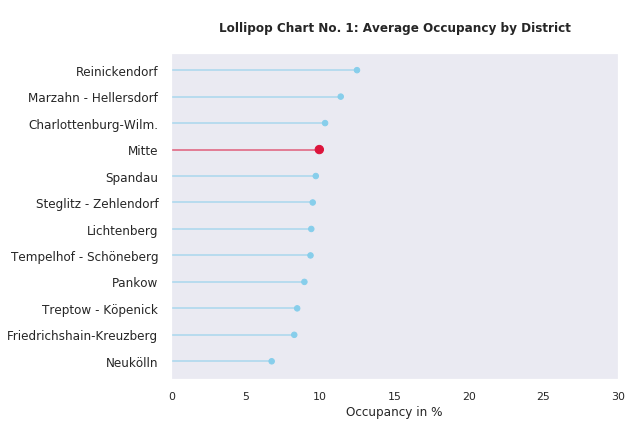

In [40]:
lollipop_highlight(df, 'neighbourhood_group', 'Mitte', 'low_occupancy')

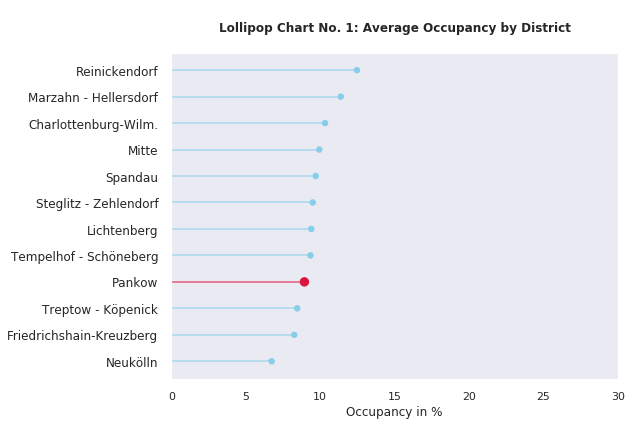

In [41]:
lollipop_highlight(df, 'neighbourhood_group', 'Pankow', 'low_occupancy')

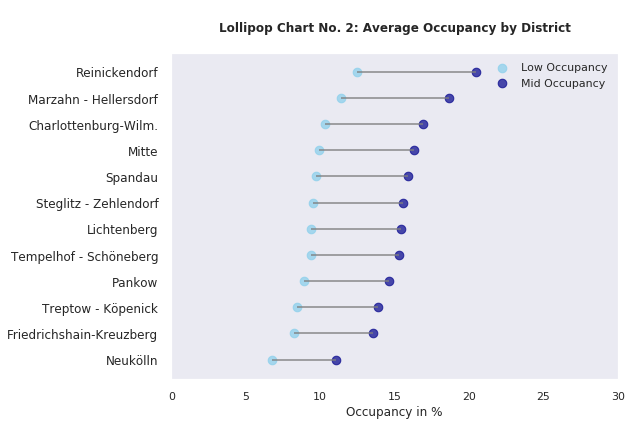

In [170]:
# prepare data
df_plot = df[['neighbourhood_group', 'low_occupancy', 'mid_occupancy']]\
            .groupby('neighbourhood_group')\
            .apply(lambda x: x.mean())
df_plot.sort_values('low_occupancy', inplace=True)
df_plot.reset_index(inplace=True)

# draw plot
fig, ax = plt.subplots(figsize=(8,6))
ax.hlines (y=df_plot.index, xmin=df_plot.low_occupancy, xmax=df_plot.mid_occupancy, 
           color='grey', alpha=0.7, linewidth=2)
ax.scatter(y=df_plot.index, x=df_plot.low_occupancy, s=75, color='skyblue', alpha=0.7, label='Low Occupancy')
ax.scatter(y=df_plot.index, x=df_plot.mid_occupancy, s=75, color='darkblue', alpha=0.7, label='Mid Occupancy')
ax.legend()

# title, label, ticks and xlim
ax.set_title('\nLollipop Chart No. 2: Average Occupancy by District\n', fontdict={'size':12, 'weight':'bold'})
ax.set_xlabel('Occupancy in %')
ax.set_yticks(df_plot.index)
ax.set_yticklabels(df_plot.neighbourhood_group, rotation=0, 
                   fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_xlim(0, 30)
plt.show()

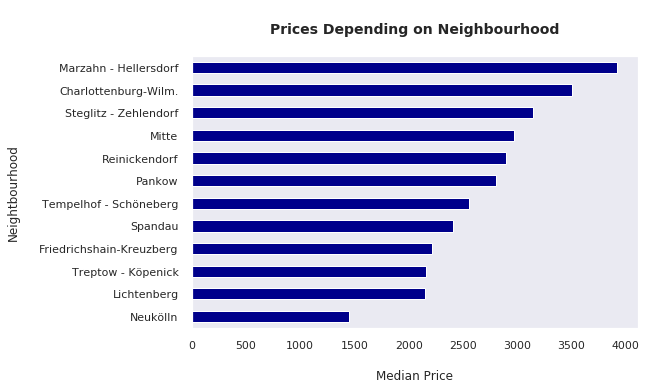

In [171]:
df.groupby('neighbourhood_group')['low_earnings']\
                      .median().sort_values()\
                      .plot(kind='barh', sort_columns=True, figsize=(8,5), color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Neightbourhood\n', fontsize=12)
plt.title('\nPrices Depending on Neighbourhood\n', fontsize=14, fontweight='bold');

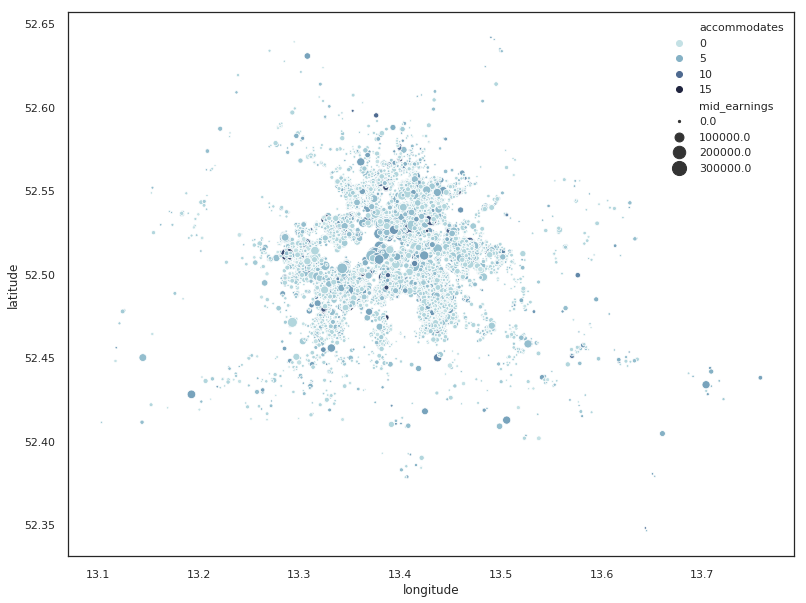

In [43]:
sns.set_style("white")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(13,10))
ax = sns.scatterplot(x="longitude", y="latitude", size='mid_earnings', sizes=(5, 200),
                     hue='accommodates', palette=cmap,  data=df)

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.3. Demand by Size
<a id='3.3. Demand by Size'></a>

In [173]:
df.head(2)

,id,neighbourhood_group,reviews_per_month,price,cleaning_fee,total_price,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost,latitude,longitude,low_occupancy,mid_occupancy,low_earnings,mid_earnings
1,2695,Pankow,1.42,17,0,17,2,1.0,1.0,Real Bed,f,52.548513,13.404553,11.93,19.55,2433.72,3988.2
2,3176,Pankow,1.25,90,50,140,4,1.0,1.0,Real Bed,f,52.534996,13.417579,10.50,17.21,11340.00,18586.8


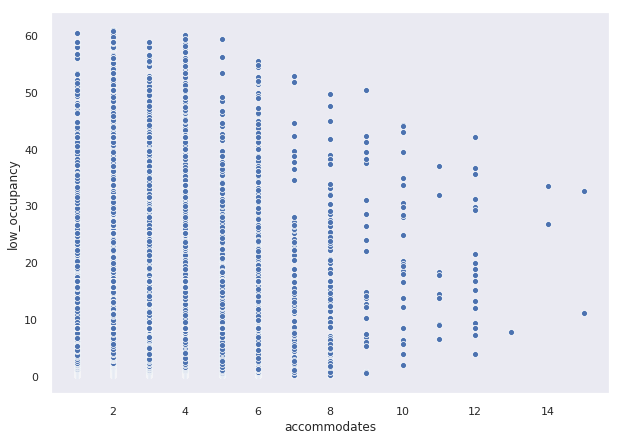

In [174]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,7))
ax = sns.scatterplot(x="accommodates", y="low_occupancy", palette=cmap,  data=df)

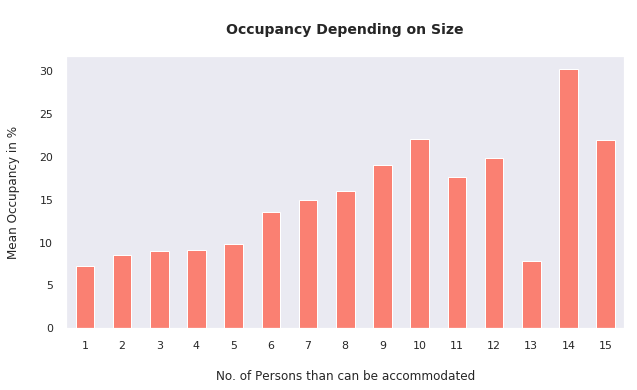

In [175]:
df.groupby('accommodates')['low_occupancy']\
                          .mean()\
                          .plot(kind='bar', figsize=(10,5), color='salmon')

plt.xlabel('\nNo. of Persons than can be accommodated', fontsize=12)
plt.xticks(rotation='horizontal')
plt.ylabel('Mean Occupancy in %\n', fontsize=12)
plt.title('\nOccupancy Depending on Size\n', fontsize=14, fontweight='bold');

In [186]:
df_bubble_plot = pd.DataFrame(df.groupby('accommodates')['low_occupancy'].mean())
df_bubble_plot.reset_index(inplace=True)
#df_bubble_plot

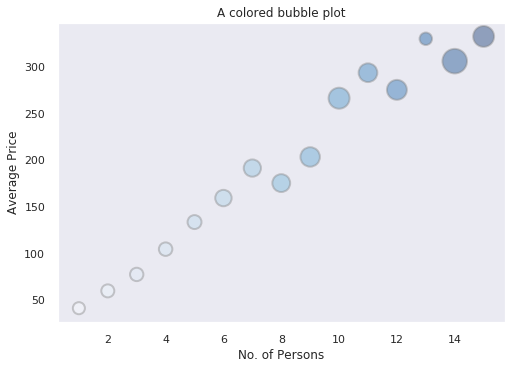

In [184]:
# create data
x = df_bubble_plot['accommodates']
y = df_bubble_plot['total_price']
z = df_bubble_plot['low_occupancy']
 
# Change color with c and alpha. I map the color to the X axis value.
plt.scatter(x, y, s=z*20, c=x, cmap="Blues", alpha=0.4, edgecolors="grey", linewidth=2)
 
# Add titles (main and on axis)
plt.xlabel("No. of Persons")
plt.ylabel("Average Price")
plt.title("A colored bubble plot")
 
plt.show()

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.4. Demand by Price
<a id='3.4. Demand by Price'></a>

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 3.5. Demand by Status "Super-Host"
<a id='3.5. Demand by Status "Super-Host"'></a>

In [ ]:
top20 =
bottom80 =

In [188]:
df.head(2)

,id,neighbourhood_group,reviews_per_month,price,cleaning_fee,total_price,accommodates,bathrooms,bedrooms,bed_type,host_is_superhost,latitude,longitude,low_occupancy,mid_occupancy,low_earnings,mid_earnings
1,2695,Pankow,1.42,17,0,17,2,1.0,1.0,Real Bed,f,52.548513,13.404553,11.93,19.55,2433.72,3988.2
2,3176,Pankow,1.25,90,50,140,4,1.0,1.0,Real Bed,f,52.534996,13.417579,10.50,17.21,11340.00,18586.8


**Occupancy Earnings by District & Status of Super-Host**

In [88]:
df.host_is_superhost.isna().sum()

14

In [89]:
# replace Nan's with no
df.host_is_superhost.fillna(value='f', inplace=True)
df.host_is_superhost.isna().sum()

0

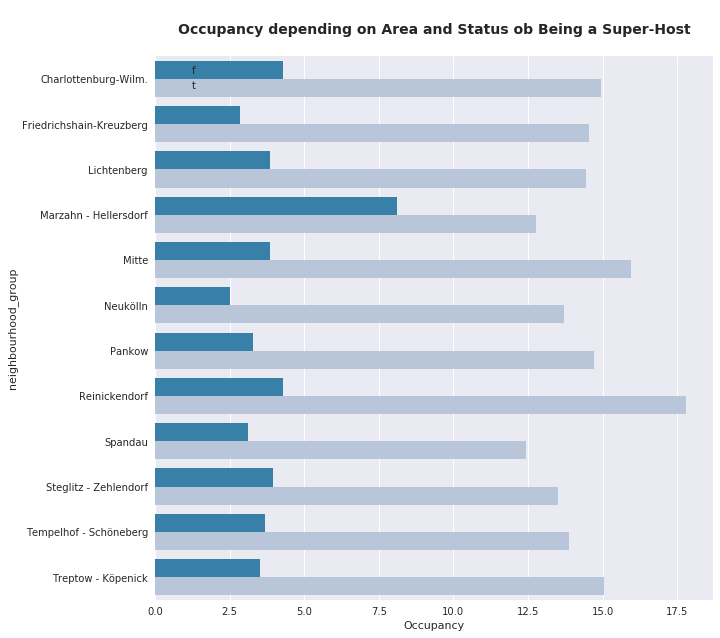

In [94]:
# now group by condition and by category of building year, then take the median price
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group', 'host_is_superhost'])['low_occupancy'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this dataframe with seaborn
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x='low_occupancy', y='neighbourhood_group', hue='host_is_superhost', data=df_grouped, palette="PuBu_r")

# add title, legend and informative axis labels
ax.set_title('\nOccupancy depending on Area and Status ob Being a Super-Host\n', fontsize=14, fontweight='bold')
ax.set(xlabel='Occupancy')
ax.legend(loc=2);

**Occupancy by Size**

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Interpreting the Data
<a id='4. Interpreting the Data'></a>

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 5. Appendix 
<a id='5. Appendix'></a>

Data
- Inside Airbnb $\;\;$ http://insideairbnb.com/get-the-data.html
- Tom Slee $\;\;\;\;\;\;\;$ http://tomslee.net/airbnb-data-collection-get-the-data ???
- TourPedia $\;\;\;\;\;\;$ http://tour-pedia.org/about/datasets.html
- TourPedia 2 $\;\;\;\;$ https://2018.semantics.cc/overview-tourpedia-linked-dataset-focus-relations-discovery-among-places

Occupancy Model
- http://insideairbnb.com/about.html
- https://www.airbnbcitizen.com/hosts-on-airbnb-have-welcomed-700000-guests-to-berlin-in-2017/
- https://www.airbnbcitizen.com/wp-content/uploads/2016/04/airbnb-community-berlin-en.pdf

Lollipop Plots
- https://python-graph-gallery.com/184-lollipop-plot-with-2-groups/
- https://python-graph-gallery.com/183-highlight-a-group-in-lollipop/
- https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/#16.-Lollipop-Chart

Bubble Plots
- https://glowingpython.blogspot.com/2011/11/how-to-make-bubble-charts-with.html
- https://seaborn.pydata.org/examples/scatterplot_sizes.html

Eventuell für später
- !!!!!https://data-viz-for-fun.com/2018/08/airbnb-data-viz/
- frische Zahlen: https://www.dehoga-bundesverband.de/fileadmin/Startseite/04_Zahlen___Fakten/07_Zahlenspiegel___Branchenberichte/Zahlenspiegel/Zahlenspiegel_1._Quartal_2018.pdf
- https://www.dehoga-bundesverband.de/fileadmin/Startseite/06_Presse/Publikationen/Wirtschaftskraft_160629.pdf
- https://www.destatis.de/DE/Publikationen/StatistischesJahrbuch/GastgewerbeTourismus.pdf?__blob=publicationFile